In [184]:
# Imports & parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

START_DATE = "2022-01-01"

In [185]:
# Load all CSV files into a dictionary of dataframes

folder = 'ohlcv_binance_perp'
dfs = {}

for filename in os.listdir(folder):
    if filename.endswith('.csv'):
        symbol = filename.replace('.csv', '')
        df = pd.read_csv(os.path.join(folder, filename), parse_dates=['date'] if 'date' in pd.read_csv(os.path.join(folder, filename), nrows=0).columns else [0])
        df = df.set_index(df.columns[0])
        df.sort_index(inplace=True)
        dfs[symbol] = df

# Build dataframes for all columns from all symbols
column_names = ["open" ,"high" , "low" , "close" ,"volume" ,"close_time" ,"quote_volume" , "count" ,"taker_buy_volume" ,"taker_buy_quote_volume" , "ignore"]

dataframes = {}

for col in column_names:
    df_combined = pd.DataFrame({symbol: df[col] for symbol, df in dfs.items()})
    df_combined = df_combined.sort_index()
    df_combined = df_combined.loc[df_combined.index >= START_DATE]
    dataframes[col] = df_combined

In [205]:
# Feature engineering

# log returns
r = np.log(dataframes["close"]).diff()

# vol-normalized return
vol = r.shift(1).rolling(30).std()
ret_z = r / vol

# relative volume + trade-count zscore
vol_mean = dataframes["volume"].shift(1).rolling(30).mean()
rvol = dataframes["volume"] / vol_mean

cnt_mean = dataframes["count"].shift(1).rolling(30).mean()
cnt_std  = dataframes["count"].shift(1).rolling(30).std()
count_z = (dataframes["count"] - cnt_mean) / cnt_std

# taker buy ratio (0..1), use quote volumes to be consistent
buy_ratio = dataframes["taker_buy_volume"] / dataframes["volume"]
buy_ratio = buy_ratio.clip(0, 1)

# Pump definition (tune thresholds)
is_pump = (ret_z > 5) & (rvol > 5) & (count_z > 5) & (buy_ratio > 0) & (vol_mean > 5000000)

In [206]:
# Analyze pump events

# Find all pump events
pump_events = is_pump.stack()
pump_events = pump_events[pump_events == True]

# Display pump events
print(f"Total pump events detected: {len(pump_events)}")

# Get next day returns (day 1 and day 2)
next_day_return = r.shift(-1)  # Day 1 return
day_2_return = r.shift(-2)      # Day 2 return

# Create a dataframe with pump events and their returns
pump_results = []

for idx, value in pump_events.items():
    date = idx[0]
    symbol = idx[1]
    
    day_1_return = next_day_return.loc[date, symbol] if date in next_day_return.index else np.nan
    day_2_return_value = day_2_return.loc[date, symbol] if date in day_2_return.index else np.nan
    
    # Conditional exit: close on day 1 if negative, otherwise on day 2
    if pd.notna(day_1_return) and day_1_return < 0:
        exit_return = day_1_return
        exit_day = 1
    elif pd.notna(day_2_return_value) and (day_1_return + day_2_return_value) < 0:
        exit_return = day_1_return + day_2_return_value
        exit_day = 2
    else:
        exit_return = day_1_return + day_2_return_value
        exit_day = 2
    
    pump_results.append({
        'date': date,
        'symbol': symbol,
        'day_1_return': day_1_return,
        'day_2_return': day_2_return_value,
        'exit_day': exit_day,
        'next_day_return': exit_return  # Keep same column name for compatibility with later cells
    })

pump_df = pd.DataFrame(pump_results)

# Summary statistics
print(f"\nExit Strategy Summary:")
print(f"Trades closed on Day 1: {(pump_df['exit_day'] == 1).sum()}")
print(f"Trades closed on Day 2: {(pump_df['exit_day'] == 2).sum()}")

pump_df.tail()

Total pump events detected: 575

Exit Strategy Summary:
Trades closed on Day 1: 384
Trades closed on Day 2: 191


,date,symbol,day_1_return,day_2_return,exit_day,next_day_return
570,2026-02-03,CHESSUSDT,0.003410,0.069749,2,0.073159
571,2026-02-06,AWEUSDT,-0.007363,0.008563,1,-0.007363
572,2026-02-07,LAUSDT,-0.131472,-0.042647,1,-0.131472
573,2026-02-07,SIRENUSDT,-1.049204,0.111499,1,-1.049204
574,2026-02-09,GPSUSDT,-0.197813,NaN,1,-0.197813


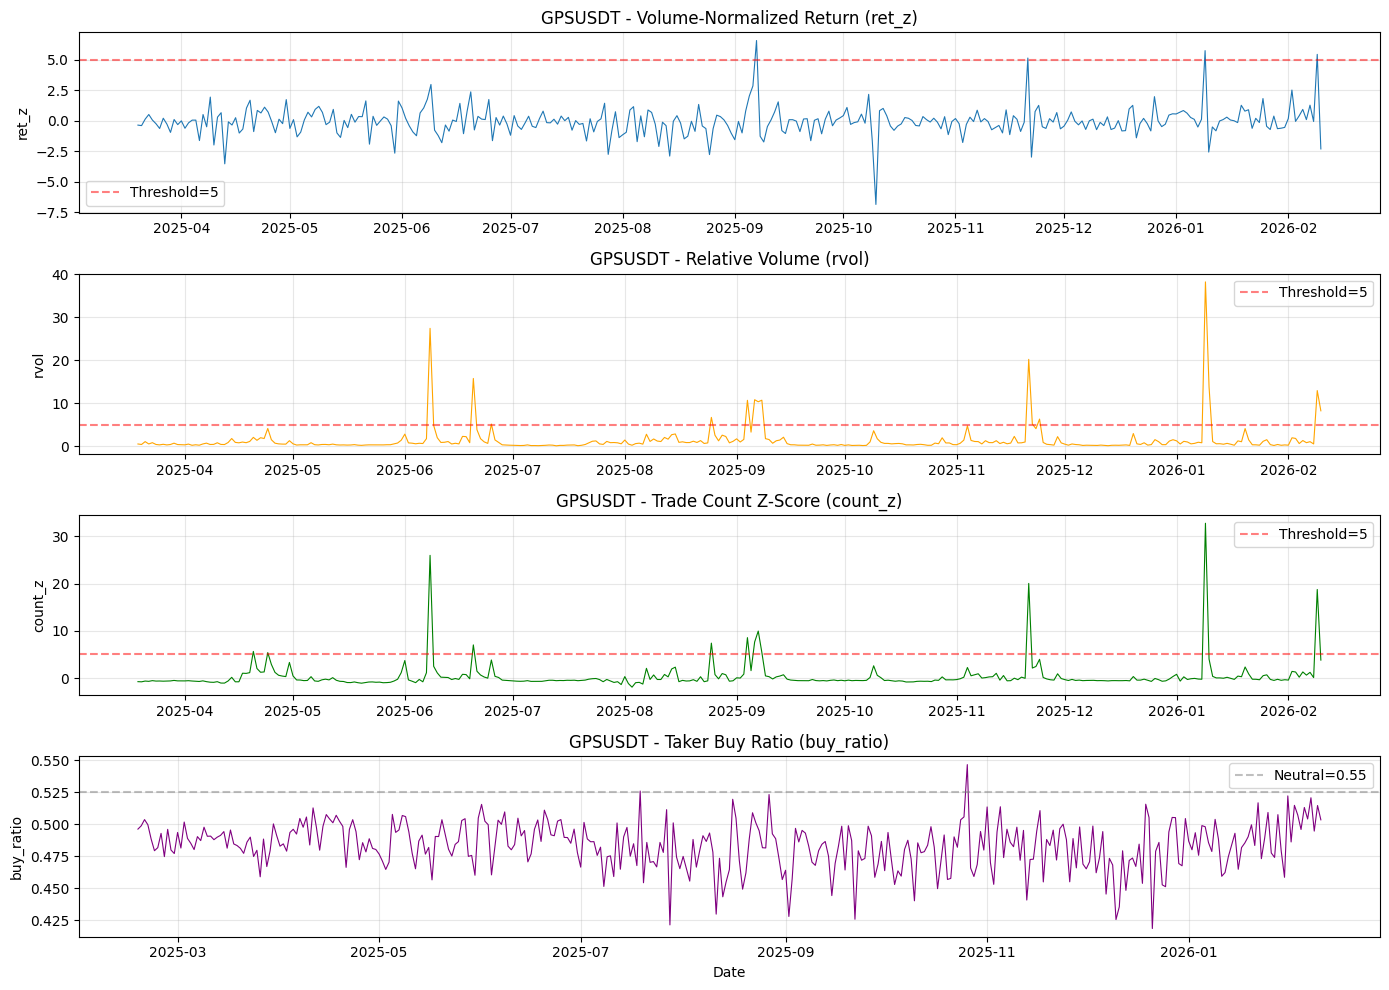


GPSUSDT - Threshold Crossings Analysis

Dates when ret_z > 5:
Count: 4
  2025-09-07: ret_z = 6.59
  2025-11-21: ret_z = 5.15
  2026-01-09: ret_z = 5.76
  2026-02-09: ret_z = 5.46

Dates when rvol > 5:
Count: 15
  2025-06-08: rvol = 27.44
  2025-06-20: rvol = 15.77
  2025-06-25: rvol = 5.15
  2025-08-25: rvol = 6.70
  2025-09-04: rvol = 10.68
  2025-09-06: rvol = 10.82
  2025-09-07: rvol = 10.34
  2025-09-08: rvol = 10.71
  2025-11-21: rvol = 20.22
  2025-11-22: rvol = 5.16
  2025-11-24: rvol = 6.30
  2026-01-09: rvol = 38.27
  2026-01-10: rvol = 13.79
  2026-02-09: rvol = 12.95
  2026-02-10: rvol = 8.24

Dates when count_z > 5:
Count: 12
  2025-04-20: count_z = 5.65
  2025-04-24: count_z = 5.40
  2025-06-08: count_z = 26.00
  2025-06-20: count_z = 7.03
  2025-08-25: count_z = 7.40
  2025-09-04: count_z = 8.57
  2025-09-06: count_z = 7.65
  2025-09-07: count_z = 9.96
  2025-09-08: count_z = 5.43
  2025-11-21: count_z = 20.05
  2026-01-09: count_z = 32.80
  2026-02-09: count_z = 18.77



In [188]:
# Visualize indicators for a specific ticker (e.g. GPSUSDT)

ticker = 'GPSUSDT'

# Create a 4-panel plot for GPSUSDT
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Plot ret_z
axes[0].plot(ret_z.index, ret_z[ticker], linewidth=0.8)
axes[0].set_title(f'{ticker} - Volume-Normalized Return (ret_z)')
axes[0].set_ylabel('ret_z')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='Threshold=5')
axes[0].legend()

# Plot rvol
axes[1].plot(rvol.index, rvol[ticker], linewidth=0.8, color='orange')
axes[1].set_title(f'{ticker} - Relative Volume (rvol)')
axes[1].set_ylabel('rvol')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='Threshold=5')
axes[1].legend()

# Plot count_z
axes[2].plot(count_z.index, count_z[ticker], linewidth=0.8, color='green')
axes[2].set_title(f'{ticker} - Trade Count Z-Score (count_z)')
axes[2].set_ylabel('count_z')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='Threshold=5')
axes[2].legend()

# Plot buy_ratio
axes[3].plot(buy_ratio.index, buy_ratio[ticker], linewidth=0.8, color='purple')
axes[3].set_title(f'{ticker} - Taker Buy Ratio (buy_ratio)')
axes[3].set_ylabel('buy_ratio')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)
axes[3].axhline(y=0.525, color='gray', linestyle='--', alpha=0.5, label='Neutral=0.55')
axes[3].legend()

plt.tight_layout()
plt.show()

# Print dates when each indicator crosses its threshold for GPSUSDT
print("\n" + "="*60)
print(f"{ticker} - Threshold Crossings Analysis")
print("="*60)

print("\nDates when ret_z > 5:")
ret_z_above = ret_z[ret_z[ticker] > 5].index
print(f"Count: {len(ret_z_above)}")
if len(ret_z_above) > 0:
    for date in ret_z_above:
        print(f"  {date.strftime('%Y-%m-%d')}: ret_z = {ret_z.loc[date, ticker]:.2f}")

print("\nDates when rvol > 5:")
rvol_above = rvol[rvol[ticker] > 5].index
print(f"Count: {len(rvol_above)}")
if len(rvol_above) > 0:
    for date in rvol_above:
        print(f"  {date.strftime('%Y-%m-%d')}: rvol = {rvol.loc[date, ticker]:.2f}")

print("\nDates when count_z > 5:")
count_z_above = count_z[count_z[ticker] > 5].index
print(f"Count: {len(count_z_above)}")
if len(count_z_above) > 0:
    for date in count_z_above:
        print(f"  {date.strftime('%Y-%m-%d')}: count_z = {count_z.loc[date, ticker]:.2f}")

print("\nDates when buy_ratio > 0.525:")
buy_ratio_above = buy_ratio[buy_ratio[ticker] > 0.525].index
print(f"Count: {len(buy_ratio_above)}")
if len(buy_ratio_above) > 0:
    for date in buy_ratio_above[:20]:  # Show first 20 to avoid too much output
        print(f"  {date.strftime('%Y-%m-%d')}: buy_ratio = {buy_ratio.loc[date, ticker]:.3f}")
    if len(buy_ratio_above) > 20:
        print(f"  ... and {len(buy_ratio_above) - 20} more dates")

print("\nDates when ALL conditions met (pump detected):")
pump_dates = is_pump[is_pump[ticker] == True].index
print(f"Count: {len(pump_dates)}")
if len(pump_dates) > 0:
    for date in pump_dates:
        print(f"  {date.strftime('%Y-%m-%d')}")

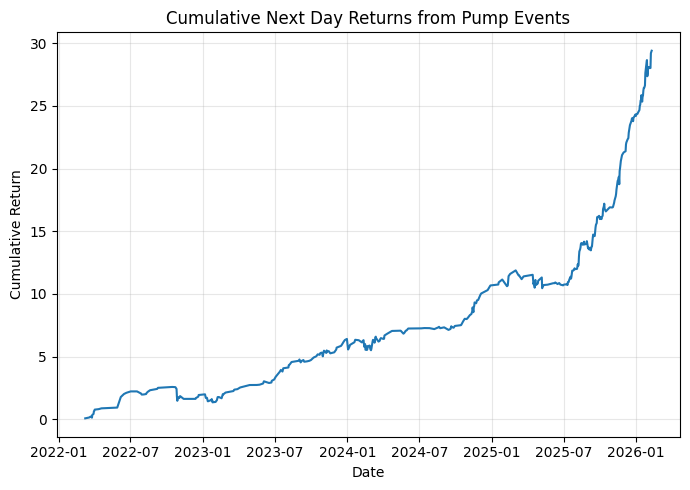

Daily Mean Return: 0.074611
Daily Std Dev: 0.234919
Annualized Return: 27.2330 (2723.30%)
Annualized Volatility: 4.4881 (448.81%)
Sharpe Ratio (Annualized): 6.0678


In [207]:
# Calculate cumulative sum of next_day_return over time
cumulative_return = pump_df.groupby('date')['next_day_return'].sum().cumsum()

# Plot cumulative returns
plt.figure(figsize=(7, 5))
plt.plot(cumulative_return.index, -cumulative_return.values)
plt.title('Cumulative Next Day Returns from Pump Events')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate Sharpe ratio for the strategy
# Use daily returns (changes in cumulative returns)
daily_returns = -pump_df.groupby('date')['next_day_return'].sum()

# Sharpe ratio calculation (annualized)
mean_return = daily_returns.mean()
std_return = daily_returns.std()
sharpe_ratio = (mean_return / std_return) * np.sqrt(365)  # Annualized Sharpe

# Calculate annualized return and volatility
annualized_return = mean_return * 365
annualized_volatility = std_return * np.sqrt(365)

print(f"Daily Mean Return: {mean_return:.6f}")
print(f"Daily Std Dev: {std_return:.6f}")
print(f"Annualized Return: {annualized_return:.4f} ({annualized_return*100:.2f}%)")
print(f"Annualized Volatility: {annualized_volatility:.4f} ({annualized_volatility*100:.2f}%)")
print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.4f}")